<div class="alert alert-block alert-dark">

## <center> Group Project - ABCDEATS Customer Segmentation </center> <br>
#  <center> <b> Self-Organizing Maps </center> <br>
## <center> Master Data Science and Advanced Analytics <center>
## <center> Fall Semester 2024-2025 <center>
<br>
<center> Group 36: <center> <br>
<center>Eduardo Mendes, 20240850  <br><center>
<center>Joana Esteves, 20240746 <br><center>
<center>João Afonso Freire, 20240528 <br><center>
<center>Tomás Figueiredo, 20240941  <br><center>

<div>

# Import the dataset and the libraries

Importing the necessary libraries

In [1]:
#Basic libraries libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#SOM
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from minisom import MiniSom


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_parquet("../Data_Mining_Project/Data_Preprocessed.parquet")
data.head()

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,...,cuisine_diversity,vendor_loyalty,customer_region,last_promo,payment_method,age_group,use_promo,weekend_preference,meal_time_preference,cuisine_preference
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,-1.349452,-0.389077,0.040521,-0.512036,-1.206775,-2.662974,-0.460767,-0.478193,-0.314716,-0.159471,...,-0.870187,0.673444,2360,DELIVERY,DIGI,young,True,True,dinner,CUI_Indian
5d272b9dcb,-1.491482,-0.389077,-0.625394,-0.164197,-1.206775,-2.662974,0.889569,-0.138681,-0.314716,-0.159471,...,-0.148134,0.673444,8670,DISCOUNT,DIGI,young,True,True,breakfast,CUI_American
f6d1b2ba63,1.491139,-0.824297,-0.625394,-0.164197,-1.206775,-2.662974,0.508273,-0.478193,-0.314716,-0.159471,...,-0.870187,-1.623501,4660,DISCOUNT,CASH,adult,True,True,breakfast,CUI_American
180c632ed8,0.070843,-0.389077,-0.403423,-0.512036,-1.206775,-2.619989,-0.460767,0.249713,-0.314716,-0.159471,...,-0.148134,0.673444,4660,DELIVERY,DIGI,adult,True,False,lunch,CUI_Indian
4eb37a6705,-1.065393,-0.389077,0.040521,-0.859876,-1.206775,-2.619989,1.073897,1.693303,-0.314716,-0.159471,...,-0.148134,0.673444,4660,No Promo Code,DIGI,young,False,False,breakfast,CUI_Asian


In [3]:
metric_features = ["total_orders", 'avg_spent_per_order', 'vendor_loyalty', "order_frequency"]
df_metrics = data[metric_features].copy()
df_metrics.head()

,total_orders,avg_spent_per_order,vendor_loyalty,order_frequency
customer_id,,,,
1b8f824d5e,-0.522007,0.586886,0.673444,1.527999
5d272b9dcb,-0.522007,-0.065365,0.673444,1.527999
f6d1b2ba63,-0.522007,-0.740550,-1.623501,1.527999
180c632ed8,-0.522007,0.767655,0.673444,0.733324
4eb37a6705,-0.522007,2.378385,0.673444,0.733324


### __FUNCTIONS__

In [4]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)




    return sf 

## 1.0 Self-Organizing Maps (SOM)

### 1.0.0 Building a SOM

In [5]:
# Phase 1: Unfolding
M = 10  # SOM grid size: 10x10
N = 10
neighborhood_function = 'gaussian'  # Gaussian neighborhood function
topology = 'hexagonal'  # Hexagonal topology
n_feats = len(metric_features)  # Number of input features
learning_rate = 0.7  # Higher learning rate for unfolding phase

# Prepare the data
som_data = df_metrics.values

# Initialize the SOM
sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean', 
             random_seed=42
             )


sm.random_weights_init(som_data)


for i in range(0, 60000, 20000):  #increase iterations 
    sm.train_batch(som_data, 20000)
    print(f"Iteration {i + 20000}: QE={sm.quantization_error(som_data):.4f}, TE={sm.topographic_error(som_data):.4f}")

print(f"QE={sm.quantization_error(som_data):.4f}")
print(f"TE={sm.topographic_error(som_data):.4f}")


Iteration 20000: QE=0.2854, TE=0.1906
Iteration 40000: QE=0.2799, TE=0.2066
Iteration 60000: QE=0.2829, TE=0.1659
QE=0.2829
TE=0.1659


### 1.0.1 SOM for visualization purposes


##### 1.0.1.1 Component Planes

In [6]:
# What are these weights?
weights = sm.get_weights()
weights.shape

(10, 10, 4)

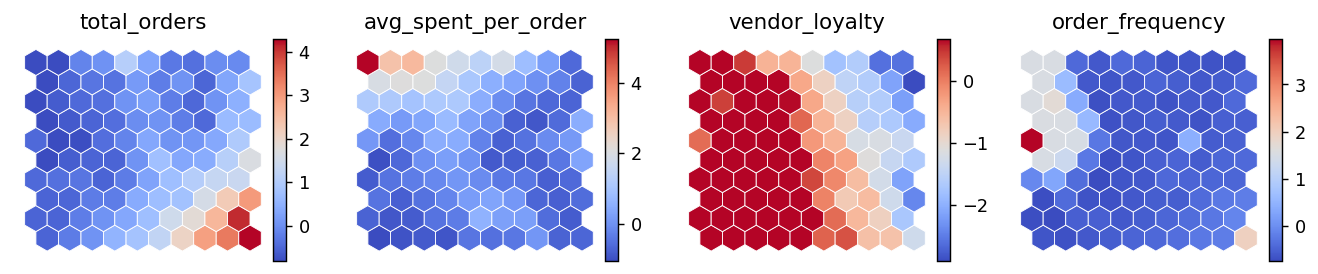

In [7]:
##############################
# Plot Component Planes
##############################

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(1,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=metric_features[cpi],
                    cmap=cm.coolwarm,
                    )

- predominance of low total_orders and order_frequency
- vendor_loyalty: There is a clear segmentation of customers in terms of their loyalty to vendors

##### 1.0.1.2 U-matrix

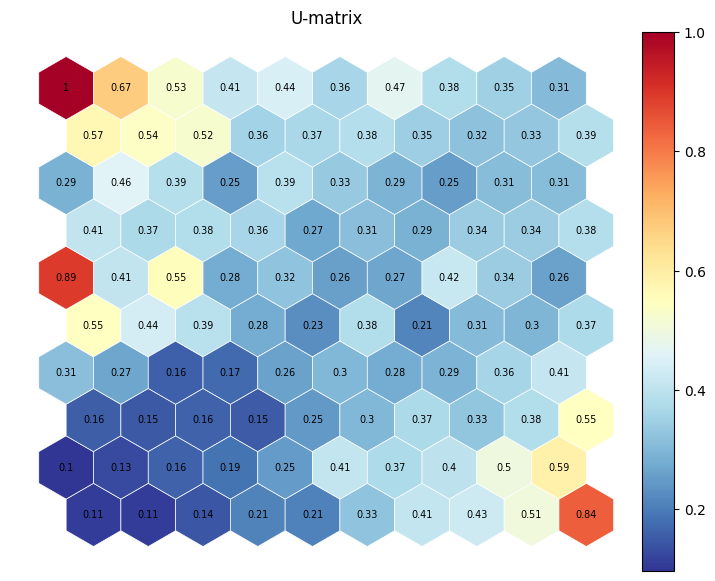

In [8]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

- bottom-left region shows the most homogenous area with small distances between nodes. Maybe a well-formed cluster.
- the red hexagon with a value of 1.0  and the right bottom one clearly marks a strong boundary between two clusters.

##### 1.0.1.3 Hit-map

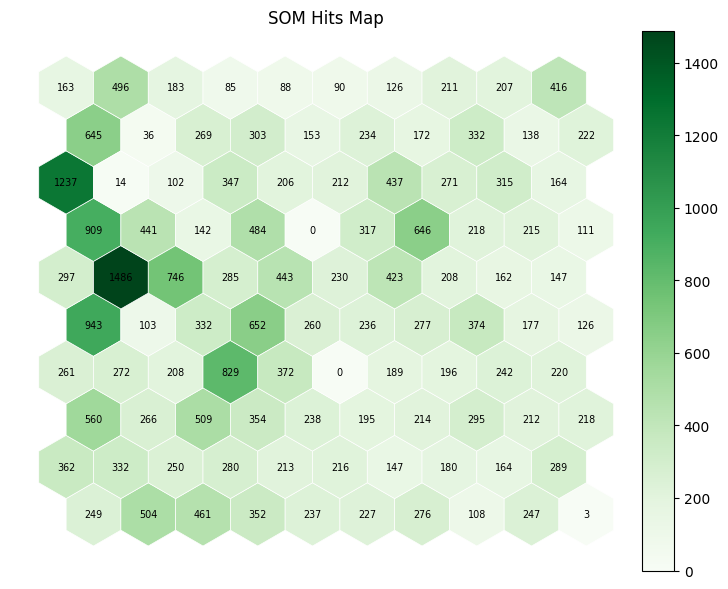

In [9]:
hitsmatrix = sm.activation_response(df_metrics.values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )

### 1.0.2 Clustering on top of a self-organizing map

In [10]:
M = 50
N = 50
neighborhood_function = 'gaussian'
topology = 'hexagonal'
n_feats = len(metric_features)
learning_rate = 0.7

som_data = df_metrics.values  

sm = MiniSom(M, N, n_feats, 
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean', 
             random_seed=42)

sm.random_weights_init(som_data)

print(np.round(sm.quantization_error(som_data), 4), "Starting QE")
print(np.round(sm.topographic_error(som_data), 4), "Starting TE")

print("\nUnfolding phase...")
sm.sigma = 15.0
sm.learning_rate = 1.5
for i in range(0, 150000, 20000):
    sm.train_batch(som_data, 20000)  
    print(f"Iteração {i + 20000}: QE={sm.quantization_error(som_data):.4f}, TE={sm.topographic_error(som_data):.4f}")
    sm.sigma *= 0.9  

print("\nFine-Tuning...")
sm.sigma = 2.0
sm.learning_rate = 0.8
for i in range(0, 550000, 100000):
    sm.train_batch(som_data, 50000)  
    print(f"Iteração {i + 50000}: QE={sm.quantization_error(som_data):.4f}, TE={sm.topographic_error(som_data):.4f}")
    sm.sigma *= 0.9 

print("After Fine Tuning Phase::")
print(f"QE={sm.quantization_error(som_data):.4f}")
print(f"TE={sm.topographic_error(som_data):.4f}")


0.0777 Starting QE
0.9976 Starting TE

Unfolding phase...
Iteração 20000: QE=0.0884, TE=0.3670
Iteração 40000: QE=0.0854, TE=0.3049
Iteração 60000: QE=0.0832, TE=0.2929
Iteração 80000: QE=0.0808, TE=0.2777
Iteração 100000: QE=0.0810, TE=0.2687
Iteração 120000: QE=0.0799, TE=0.2538
Iteração 140000: QE=0.0794, TE=0.2394
Iteração 160000: QE=0.0790, TE=0.2402

Fine-Tuning...
Iteração 50000: QE=0.0651, TE=0.2782
Iteração 150000: QE=0.0637, TE=0.2640
Iteração 250000: QE=0.0634, TE=0.2523
Iteração 350000: QE=0.0628, TE=0.2377
Iteração 450000: QE=0.0625, TE=0.2239
Iteração 550000: QE=0.0615, TE=0.2083
After Fine Tuning Phase::
QE=0.0615
TE=0.2083


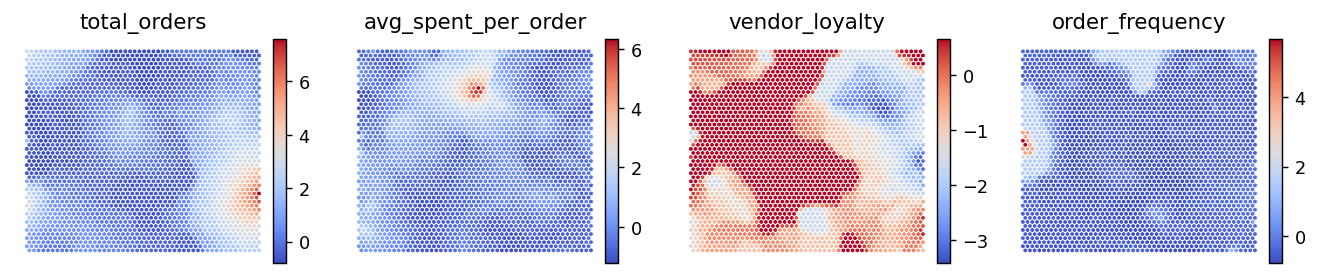

In [73]:
##############################
# Plot Component Planes
##############################

weights = sm.get_weights()

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(1,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=metric_features[cpi],
                    cmap=cm.coolwarm,
                    )

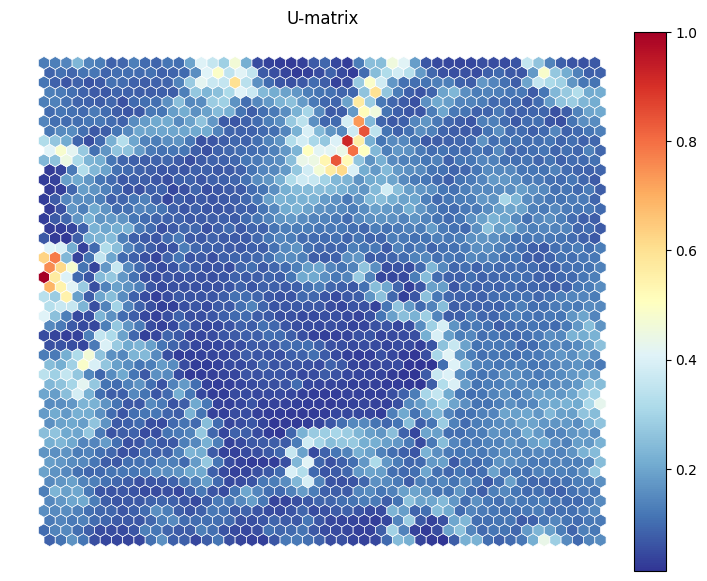

In [74]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    )

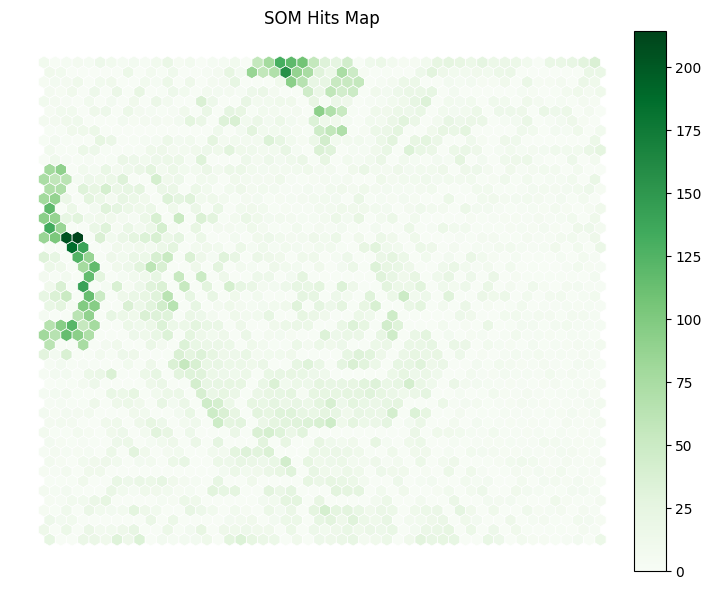

In [75]:
hitsmatrix = sm.activation_response(data[metric_features].values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    )

#### K-Means on top of SOM units

In [76]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_metrics)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

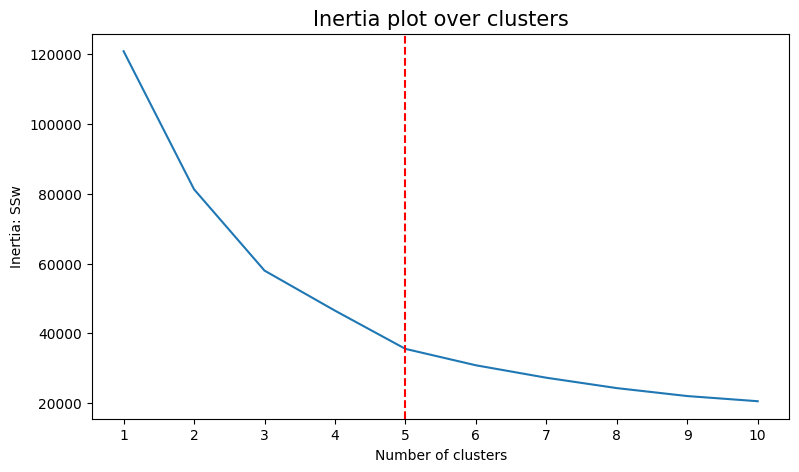

In [77]:
# The inertia plot

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
plt.axvline(x=5, color='red', linestyle='--', linewidth=1.5)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

In [78]:
weights_flat = sm.get_weights().reshape((M*N),len(metric_features))
weights_flat.shape

(2500, 4)

In [79]:
# Perform K-Means clustering on top of the MxN units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=20, random_state=42)
nodeclus_labels_k = kmeans.fit_predict(weights_flat)
nodeclus_labels_k

array([2, 2, 2, ..., 4, 4, 4], dtype=int32)

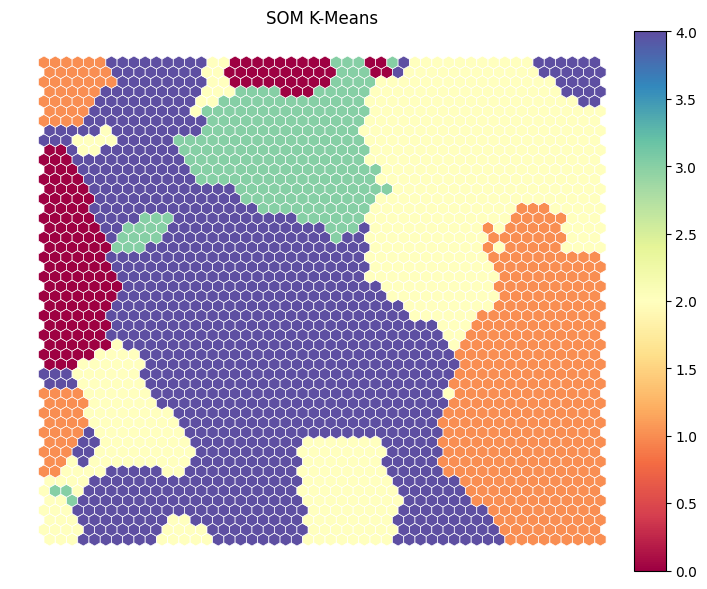

In [80]:
kmeans_matrix = nodeclus_labels_k.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

#### Hierarchical Clustering on top of SOM units


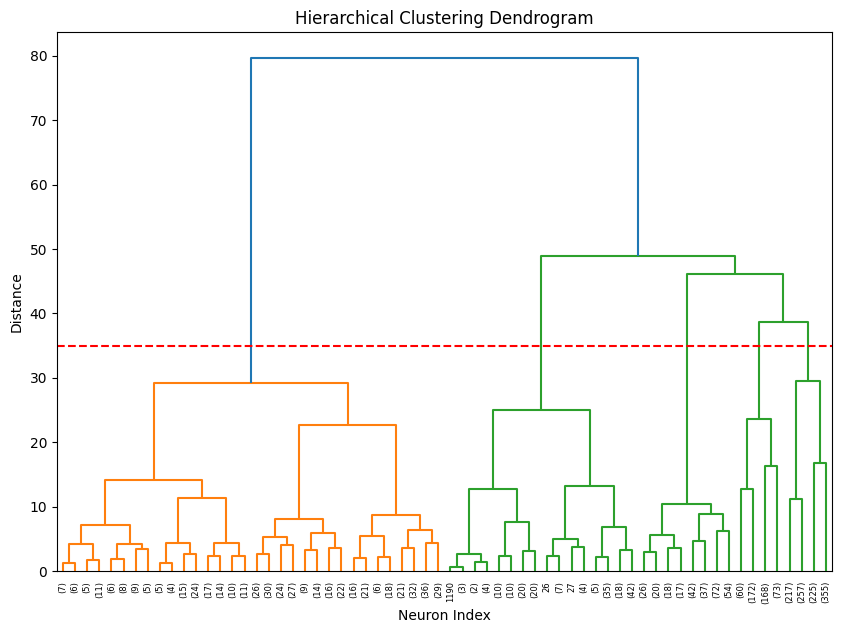

In [81]:

# Compute the linkage matrix (Ward's method minimizes variance within clusters)
linkage_matrix = linkage(weights_flat, method='ward')  

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate to 5 levels for readability
plt.axhline(y=35, color='red', linestyle='--', linewidth=1.5)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Neuron Index")
plt.ylabel("Distance")
plt.show()

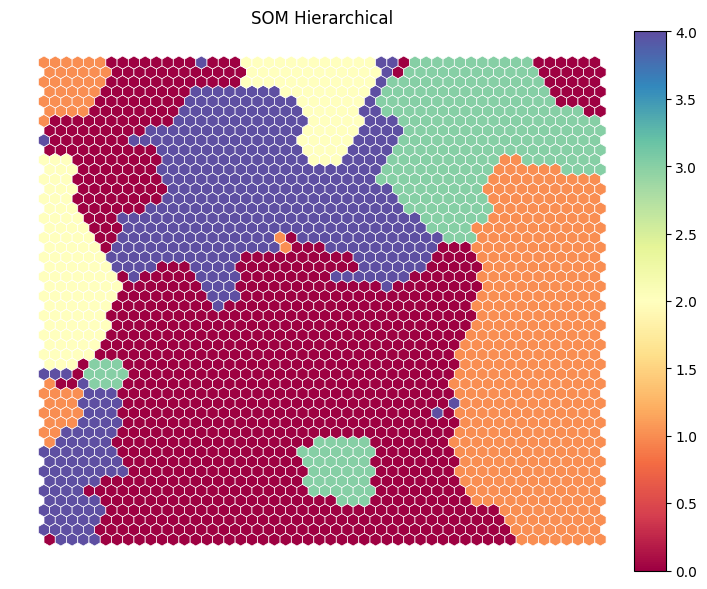

In [82]:
# Perform Hierarchical clustering on top of the MxN units 

hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
nodeclus_labels_h = hierclust.fit_predict(weights_flat)
hclust_matrix = nodeclus_labels_h.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )



In [83]:
# Check the nodes and and respective clusters
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label_h'] = nodeclus_labels_h
df_nodes['label_k'] = nodeclus_labels_k
df_nodes


,total_orders,avg_spent_per_order,vendor_loyalty,order_frequency,label_h,label_k
0,0.931318,-0.102820,-1.295361,-0.585617,0,2
1,0.931310,0.086417,-1.295348,-0.593627,4,2
2,0.929084,0.347096,-1.291997,-0.574649,4,2
3,0.935103,0.683517,-1.295934,-0.385645,4,2
4,1.012270,1.239249,-1.309935,-0.545384,4,2
...,...,...,...,...,...,...
2495,0.322291,-0.359454,-0.156307,0.034675,0,4
2496,0.178048,-0.386896,0.657556,0.062901,0,4
2497,-0.249079,-0.617545,0.673426,0.018528,0,4
2498,-0.516969,-0.798042,0.673444,0.080413,0,4


In [84]:
cluster_labels_h = nodeclus_labels_h  # Cluster labels obtained from hierarchical clustering
cluster_labels_h


array([0, 4, 4, ..., 0, 0, 0])

In [85]:
# Map each data point to its BMU
bmu_indices = np.array([sm.winner(x) for x in som_data])

# Assign hierarchical clusters to data points
data['hierarchical_cluster'] = [df_nodes['label_h'][bmu[0] * M + bmu[1]] for bmu in bmu_indices]

# Assign K-Means clusters to data points
data['kmeans_cluster'] = [df_nodes['label_k'][bmu[0] * M + bmu[1]] for bmu in bmu_indices]


In [86]:
#hierarchical cluster
hierarchical_counts = data['hierarchical_cluster'].value_counts()
print("Number of observations for each cluster - Hierarchical Clustering")
for cluster, count in hierarchical_counts.items():
    print(f"Cluster {cluster}: {count} observations")

#K-means cluster
kmeans_counts = data['kmeans_cluster'].value_counts()
print("\nNumber of observations for each cluster - K-means Clustering")
for cluster, count in kmeans_counts.items():
    print(f"Cluster {cluster}: {count} observations")

Number of observations for each cluster - Hierarchical Clustering
Cluster 0: 12878 observations
Cluster 2: 7487 observations
Cluster 4: 4709 observations
Cluster 3: 2628 observations
Cluster 1: 2509 observations

Number of observations for each cluster - K-means Clustering
Cluster 4: 12463 observations
Cluster 0: 6505 observations
Cluster 2: 6114 observations
Cluster 3: 2997 observations
Cluster 1: 2132 observations


In [87]:
hierarchical_profiles = data.groupby('hierarchical_cluster')[metric_features].mean()
hierarchical_profiles


,total_orders,avg_spent_per_order,vendor_loyalty,order_frequency
hierarchical_cluster,,,,
0,-0.035112,-0.463538,0.254031,-0.544863
1,2.542205,-0.516033,-1.256442,-0.420074
2,-0.780877,0.469622,0.643793,1.627223
3,-0.020642,-0.356622,-1.989802,-0.568593
4,-0.005426,0.994970,0.061611,-0.555966


### Kmeans profiles

In [88]:
kmeans_profiles = data.groupby('kmeans_cluster')[metric_features].mean()
kmeans_profiles

,total_orders,avg_spent_per_order,vendor_loyalty,order_frequency
kmeans_cluster,,,,
0,-0.762225,-0.008509,0.616647,1.621314
1,2.783702,-0.483227,-0.990429,-0.404711
2,0.183406,-0.307920,-1.528934,-0.557337
3,-0.440927,2.216070,0.470545,0.309397
4,-0.062302,-0.294740,0.484473,-0.577991


### Silhouette Scores

In [89]:
# Compute Silhouette Score for Hierarchical Clustering
hierarchical_silhouette = silhouette_score(
    som_data, 
    data['hierarchical_cluster'],
)

print(f"Silhouette Score (Hierarchical Clustering): {hierarchical_silhouette:.4f}")


Silhouette Score (Hierarchical Clustering): 0.3198


In [90]:
# Compute Silhouette Score for K-Means
kmeans_silhouette = silhouette_score(
    som_data,  
    data['kmeans_cluster'],  
)

print(f"Silhouette Score (K-Means): {kmeans_silhouette:.4f}")


Silhouette Score (K-Means): 0.4235


### Trying with 4 clusters

In [92]:
# Perform K-Means clustering on top of the MxN units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels_k = kmeans.fit_predict(weights_flat)
nodeclus_labels_k

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

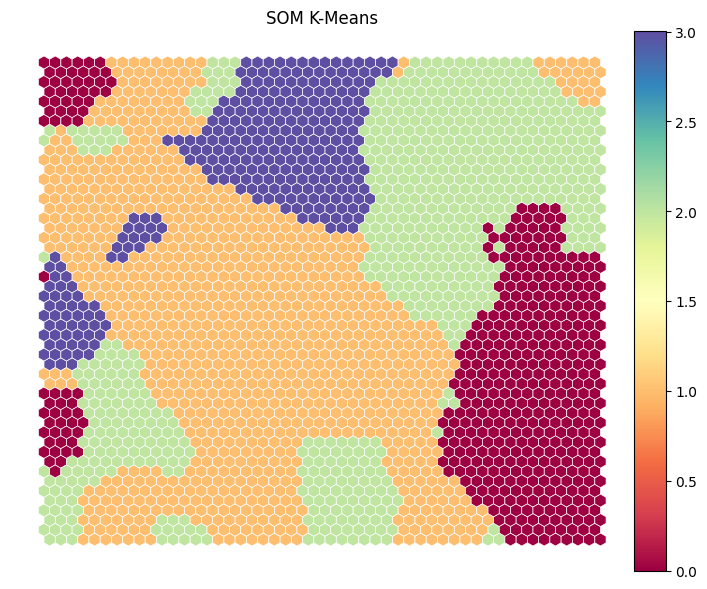

In [93]:
kmeans_matrix = nodeclus_labels_k.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

#### Hierarchical Clustering on top of SOM units


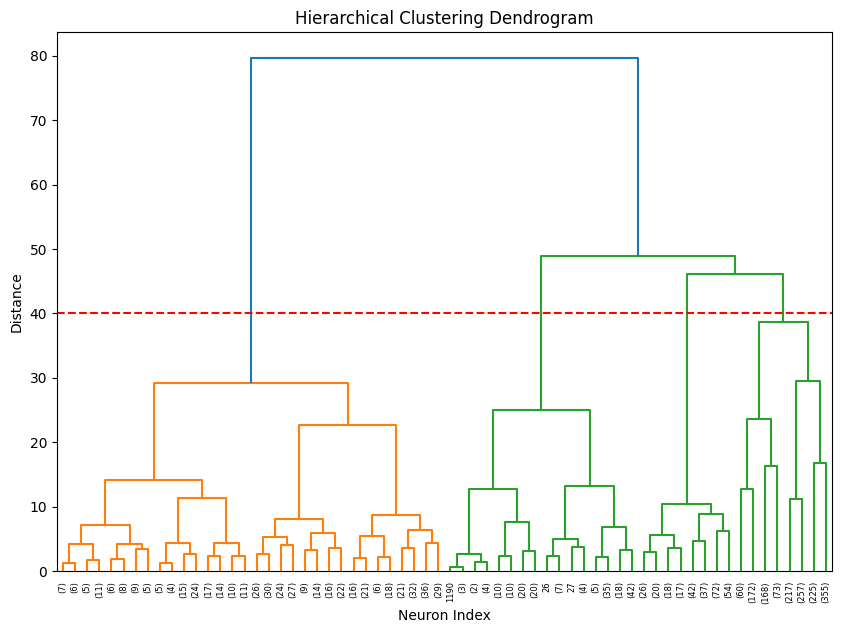

In [94]:

# Compute the linkage matrix (Ward's method minimizes variance within clusters)
linkage_matrix = linkage(weights_flat, method='ward') 

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate to 5 levels for readability
plt.axhline(y=40, color='red', linestyle='--', linewidth=1.5)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Neuron Index")
plt.ylabel("Distance")
plt.show()

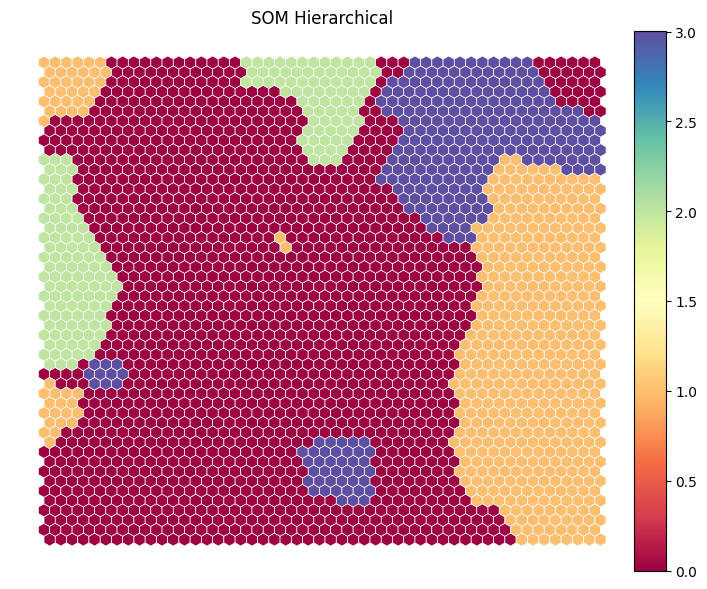

In [95]:
# Perform Hierarchical clustering on top of the MxN units 

hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels_h = hierclust.fit_predict(weights_flat)
hclust_matrix = nodeclus_labels_h.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )



In [96]:
# Check the nodes and and respective clusters
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label_h'] = nodeclus_labels_h
df_nodes['label_k'] = nodeclus_labels_k
df_nodes


,total_orders,avg_spent_per_order,vendor_loyalty,order_frequency,label_h,label_k
0,0.931318,-0.102820,-1.295361,-0.585617,0,2
1,0.931310,0.086417,-1.295348,-0.593627,0,2
2,0.929084,0.347096,-1.291997,-0.574649,0,2
3,0.935103,0.683517,-1.295934,-0.385645,0,2
4,1.012270,1.239249,-1.309935,-0.545384,0,2
...,...,...,...,...,...,...
2495,0.322291,-0.359454,-0.156307,0.034675,0,1
2496,0.178048,-0.386896,0.657556,0.062901,0,1
2497,-0.249079,-0.617545,0.673426,0.018528,0,1
2498,-0.516969,-0.798042,0.673444,0.080413,0,1


In [97]:
# Map each data point to its BMU
bmu_indices = np.array([sm.winner(x) for x in som_data])

# Assign hierarchical clusters to data points
data['hierarchical_cluster'] = [df_nodes['label_h'][bmu[0] * M + bmu[1]] for bmu in bmu_indices]

# Assign K-Means clusters to data points
data['kmeans_cluster'] = [df_nodes['label_k'][bmu[0] * M + bmu[1]] for bmu in bmu_indices]


In [98]:
#hierarchical cluster
hierarchical_counts = data['hierarchical_cluster'].value_counts()
print("Number of observations for each cluster - Hierarchical Clustering")
for cluster, count in hierarchical_counts.items():
    print(f"Cluster {cluster}: {count} observations")

#K-means cluster
kmeans_counts = data['kmeans_cluster'].value_counts()
print("\nNumber of observations for each cluster - K-means Clustering")
for cluster, count in kmeans_counts.items():
    print(f"Cluster {cluster}: {count} observations")

Number of observations for each cluster - Hierarchical Clustering
Cluster 0: 17587 observations
Cluster 2: 7487 observations
Cluster 3: 2628 observations
Cluster 1: 2509 observations

Number of observations for each cluster - K-means Clustering
Cluster 1: 15581 observations
Cluster 2: 6429 observations
Cluster 3: 6059 observations
Cluster 0: 2142 observations


In [99]:
hierarchical_profiles = data.groupby('hierarchical_cluster')[metric_features].mean()
hierarchical_profiles


,total_orders,avg_spent_per_order,vendor_loyalty,order_frequency
hierarchical_cluster,,,,
0,-0.027163,-0.073016,0.202509,-0.547836
1,2.542205,-0.516033,-1.256442,-0.420074
2,-0.780877,0.469622,0.643793,1.627223
3,-0.020642,-0.356622,-1.989802,-0.568593


### Kmeans profiles

In [100]:
kmeans_profiles = data.groupby('kmeans_cluster')[metric_features].mean()
kmeans_profiles

,total_orders,avg_spent_per_order,vendor_loyalty,order_frequency
kmeans_cluster,,,,
0,2.777768,-0.488092,-0.997262,-0.387057
1,-0.221230,-0.360289,0.531965,-0.148066
2,0.197672,-0.289488,-1.498973,-0.513801
3,-0.622845,1.406218,0.575093,1.062768


### Silhouette Scores

In [101]:
# Compute Silhouette Score for Hierarchical Clustering
hierarchical_silhouette = silhouette_score(
    som_data, 
    data['hierarchical_cluster'],
)

print(f"Silhouette Score (Hierarchical Clustering): {hierarchical_silhouette:.4f}")


Silhouette Score (Hierarchical Clustering): 0.3610


In [102]:
# Compute Silhouette Score for K-Means
kmeans_silhouette = silhouette_score(
    som_data,  
    data['kmeans_cluster'],  
)

print(f"Silhouette Score (K-Means): {kmeans_silhouette:.4f}")


Silhouette Score (K-Means): 0.3298


# Silhouette Scores:
  
- K-Means 5 Clusters: 0.33
- Hierachical 5 Clusters: 0.361
  
- K-Means 4 Clusters: 0.424
- Hierachical 4 Clusters: 0.32